In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

In [ ]:
def parser(s):
  return datetime.strptime(s, '%Y-%m-%d')

In [ ]:
prod_ice = pd.read_csv('/content/ice_cream (1).csv', parse_dates=[0], index_col=0, date_parser=parser)

<ipython-input-3-a348e0da03de>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  prod_ice = pd.read_csv('/content/ice_cream (1).csv', parse_dates=[0], index_col=0, date_parser=parser)


In [ ]:
prod_ice.rename(columns={'IPN31152N':'production'}, inplace=True)

In [ ]:
prod_ice

,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223


In [ ]:
prod_ice = prod_ice.asfreq(pd.infer_freq(prod_ice.index))

In [ ]:
start_date = pd.to_datetime('2010-01-01')
prod_ice = prod_ice[start_date:]
prod_ice

,production
DATE,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576
...,...
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223


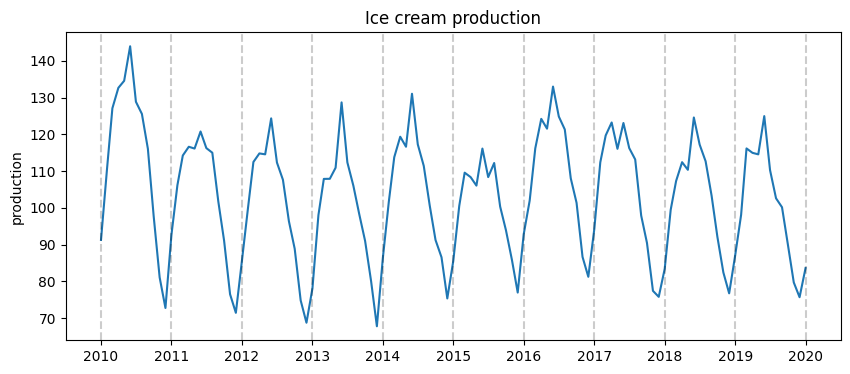

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(prod_ice)
plt.title('Ice cream production')
plt.ylabel('production')
for year in range(2010,2021):
  plt.axvline(pd.to_datetime(str(year)), color='k',linestyle='--', alpha=0.2)
plt.show()

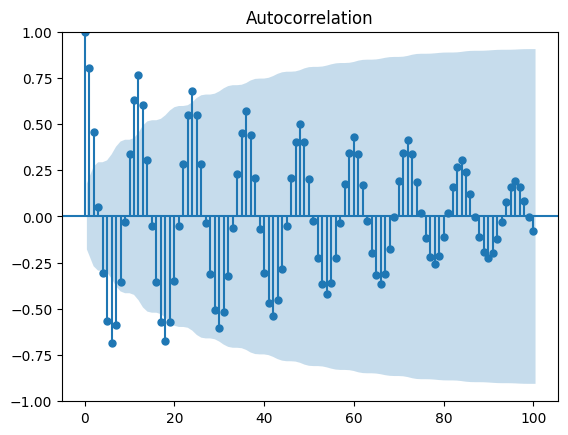

In [ ]:
# ACF
acf_plot = plot_acf(prod_ice, lags =100)

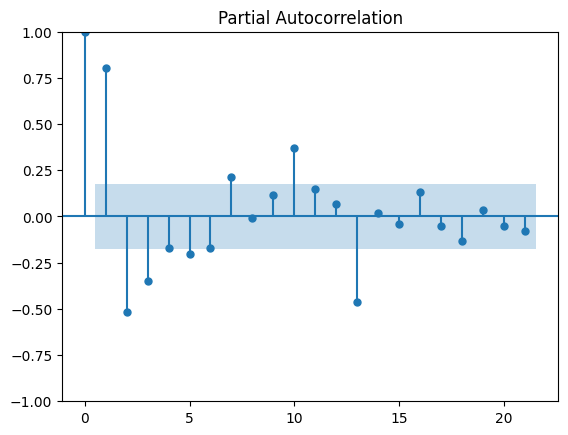

In [ ]:
plot_pacf = plot_pacf(prod_ice)

Based on this will should start with AR model with lags 1,2,3

In [ ]:
train = datetime(2016,12,1)
test = datetime(2019,12,1)

x_train = prod_ice[:train]
x_test = prod_ice[train + timedelta(days=1):test]

In [ ]:
x_train

,production
DATE,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576
...,...
2016-08-01,121.3321
2016-09-01,108.0359
2016-10-01,101.3836


In [ ]:
# simple model
model = ARIMA(x_train, order=(3,0,0))

In [ ]:
# fitting model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.09049367904663086


In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                   84
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -294.008
Date:                Wed, 05 Mar 2025   AIC                            598.015
Time:                        13:30:15   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5071      2.531     40.893      0.000      98.546     108.468
ar.L1          1.0488      0.116      9.046      0.000       0.822       1.276
ar.L2         -0.0532      0.204     -0.260      0.7

In [ ]:
pred_start = x_test.index[0]
pred_end = x_test.index[-1]

In [ ]:
n_periods = len(x_test)  # Number of periods to predict
predictions = model_fit.forecast(steps=n_periods)
predictions.index = x_test.index  # Align index with x_test

In [ ]:
residuals = x_test['production'] - predictions

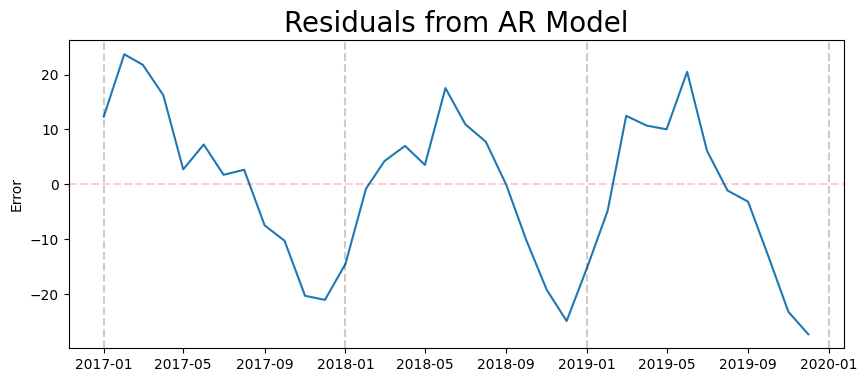

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error')
plt.axhline(0,color='r', linestyle='--', alpha=0.2)
for year in range(2017,2021):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

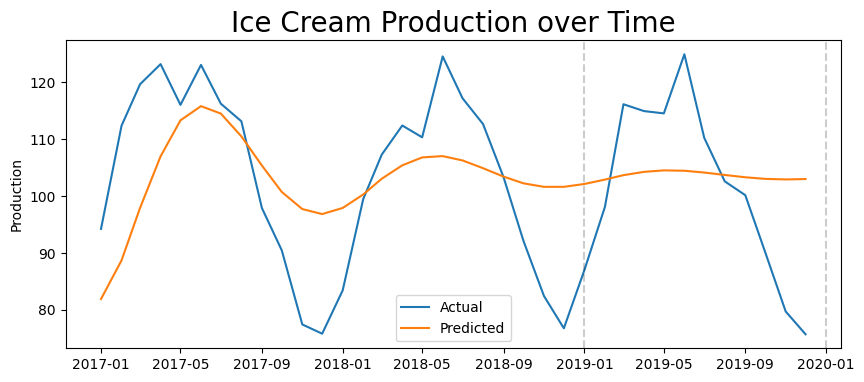

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(x_test)
plt.plot(predictions)
plt.legend(['Actual', 'Predicted'])
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production')
#plt.axhline(0,color='r', linestyle='--', alpha=0.2)
for year in range(2019,2021):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

The model performed well in the first year 2017, but started to lose its pattern as the prediction line in the figure gradually flattened more and more, eventually returning to mean reversion

In [ ]:
print('MAE: ' ,round(np.mean(abs(residuals/x_test['production'])),4))
print('RMSE: ',np.sqrt(np.mean(residuals**2)))

MAE:  0.1211
RMSE:  13.89010233431044


# **Rolling Forecast Origin**

In [ ]:
predictions_rolling = pd.Series(dtype=float)

for end_date in x_test.index:
    # Slice the training data up to the day before the current end_date
    train_data = prod_ice[:end_date - pd.Timedelta(days=1)]

    model = ARIMA(train_data, order=(3, 0, 0))
    model_fit = model.fit()

    # Forecast only one step ahead (next month)
    pred = model_fit.forecast(steps=1)

    # Assign the forecasted value to the current end_date index
    predictions_rolling.loc[end_date] = pred.iloc[0]

In [ ]:
residuals = x_test['production'] - predictions_rolling

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from Rolling AR Model', fontsize=20)
plt.ylabel('Error')
plt.axhline(0,color='r', linestyle='--', alpha=0.2)
for year in range(2017,2021):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

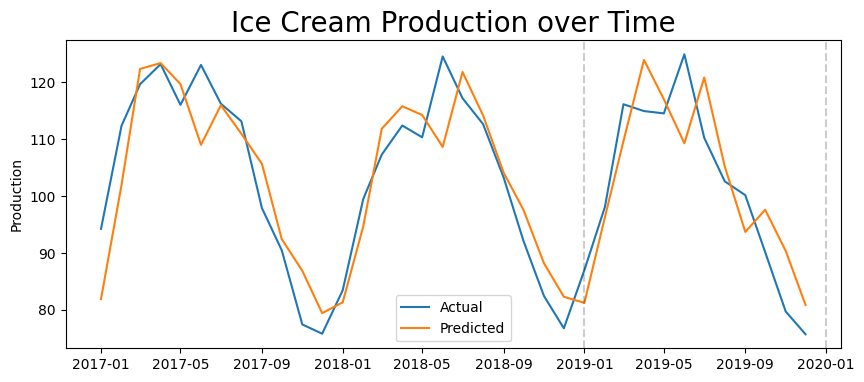

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(x_test)
plt.plot(predictions_rolling)
plt.legend(['Actual', 'Predicted'])
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production')
#plt.axhline(0,color='r', linestyle='--', alpha=0.2)
for year in range(2019,2021):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

The result is totally different the predictions are close to most of the actual values throughout the entire test period, and the overall performance has improved

In [ ]:
predictions_rolling = pd.Series()
for end_date in x_test.index:
  train_data = prod_ice[:end_date = timedelta(days=1)]
  model = ARIMA(x_train, order=(3,0,0))
  model_fit = model.fit()
  pred = model_fit.predict(end_date)
  predictions_rolling.loc[end_date] = pred.loc[end_date]